In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv("Final_cleaned_data.csv")
df.head()

,ISBN,Publisher,Book_Title,Book_Author,First_Publish_Year,Edition_Count,Book_Age,Edition_Count_Category,Total_Reviews,No_of_Pages,Book_Length_Category,Popularity_Score,Book_Price,Bestseller
0,1881320189,River City Pub,Goodbye to the Buttermilk Sky,Julia Oliver,1994,1,33,Low,189,363,Medium,113.8,32.15,1
1,0440295734,Bantam Books,The Testament,John Grisham,1999,62,26,High,588,474,Medium,377.6,37.70,1
2,0553502271,Random House Audio,The Testament,John Grisham,1999,61,26,High,8,116,Short,29.2,5.80,0
3,0439095026,Scholastic,Tell Me This Isn't Happening,Robynn Clairday,1999,1,26,Low,165,440,Medium,99.4,32.00,1
4,0060168013,Harpercollins,Pigs in Heaven,Barbara Kingsolver,1993,13,32,Medium,88,451,Medium,58.0,38.55,1


In [31]:
selected_features = ['Edition_Count', 'Book_Age', 'Book_Price']
X = df[selected_features]
y = df['Bestseller']

print("Selected Feature Data (X):")
print(X.head())

Selected Feature Data (X):
   Edition_Count  Book_Age  Book_Price
0              1        33       32.15
1             62        26       37.70
2             61        26        5.80
3              1        26       32.00
4             13        32       38.55


In [17]:
# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining Data :")
print(X_train.head())

print("\nTesting Data :")
print(X_test.head())


Training Data :
     Edition_Count  Book_Age  Book_Price
29               1        29       28.90
280             63        42       28.20
507              2        42       50.75
706              1        44       29.25
877              7        36       27.20

Testing Data :
     Edition_Count  Book_Age  Book_Price
628              1        24       68.75
631              3        35       30.25
741             22        27       47.60
514              1        46       48.55
365              1        28       35.40


In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [37]:
features_for_roots = ['Edition_Count', 'Book_Price', 'Book_Age']
trees = []

for feature in features_for_roots:
    reordered_features = [feature] + [f for f in selected_features if f != feature]
    X_train_reordered = X_resampled[reordered_features]
    X_test_reordered = X_test[reordered_features]

    model = DecisionTreeClassifier(max_depth=4, random_state=42)
    model.fit(X_train_reordered, y_resampled)

    y_pred = model.predict(X_test_reordered)
    y_proba = model.predict_proba(X_test_reordered)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    trees.append((feature, model, reordered_features, cm, acc, fpr, tpr, roc_auc))


=== Decision Tree 1 - Root Influenced by 'Edition_Count' ===
Confusion Matrix:
[[  8  20]
 [  9 165]]
Accuracy: 0.8564


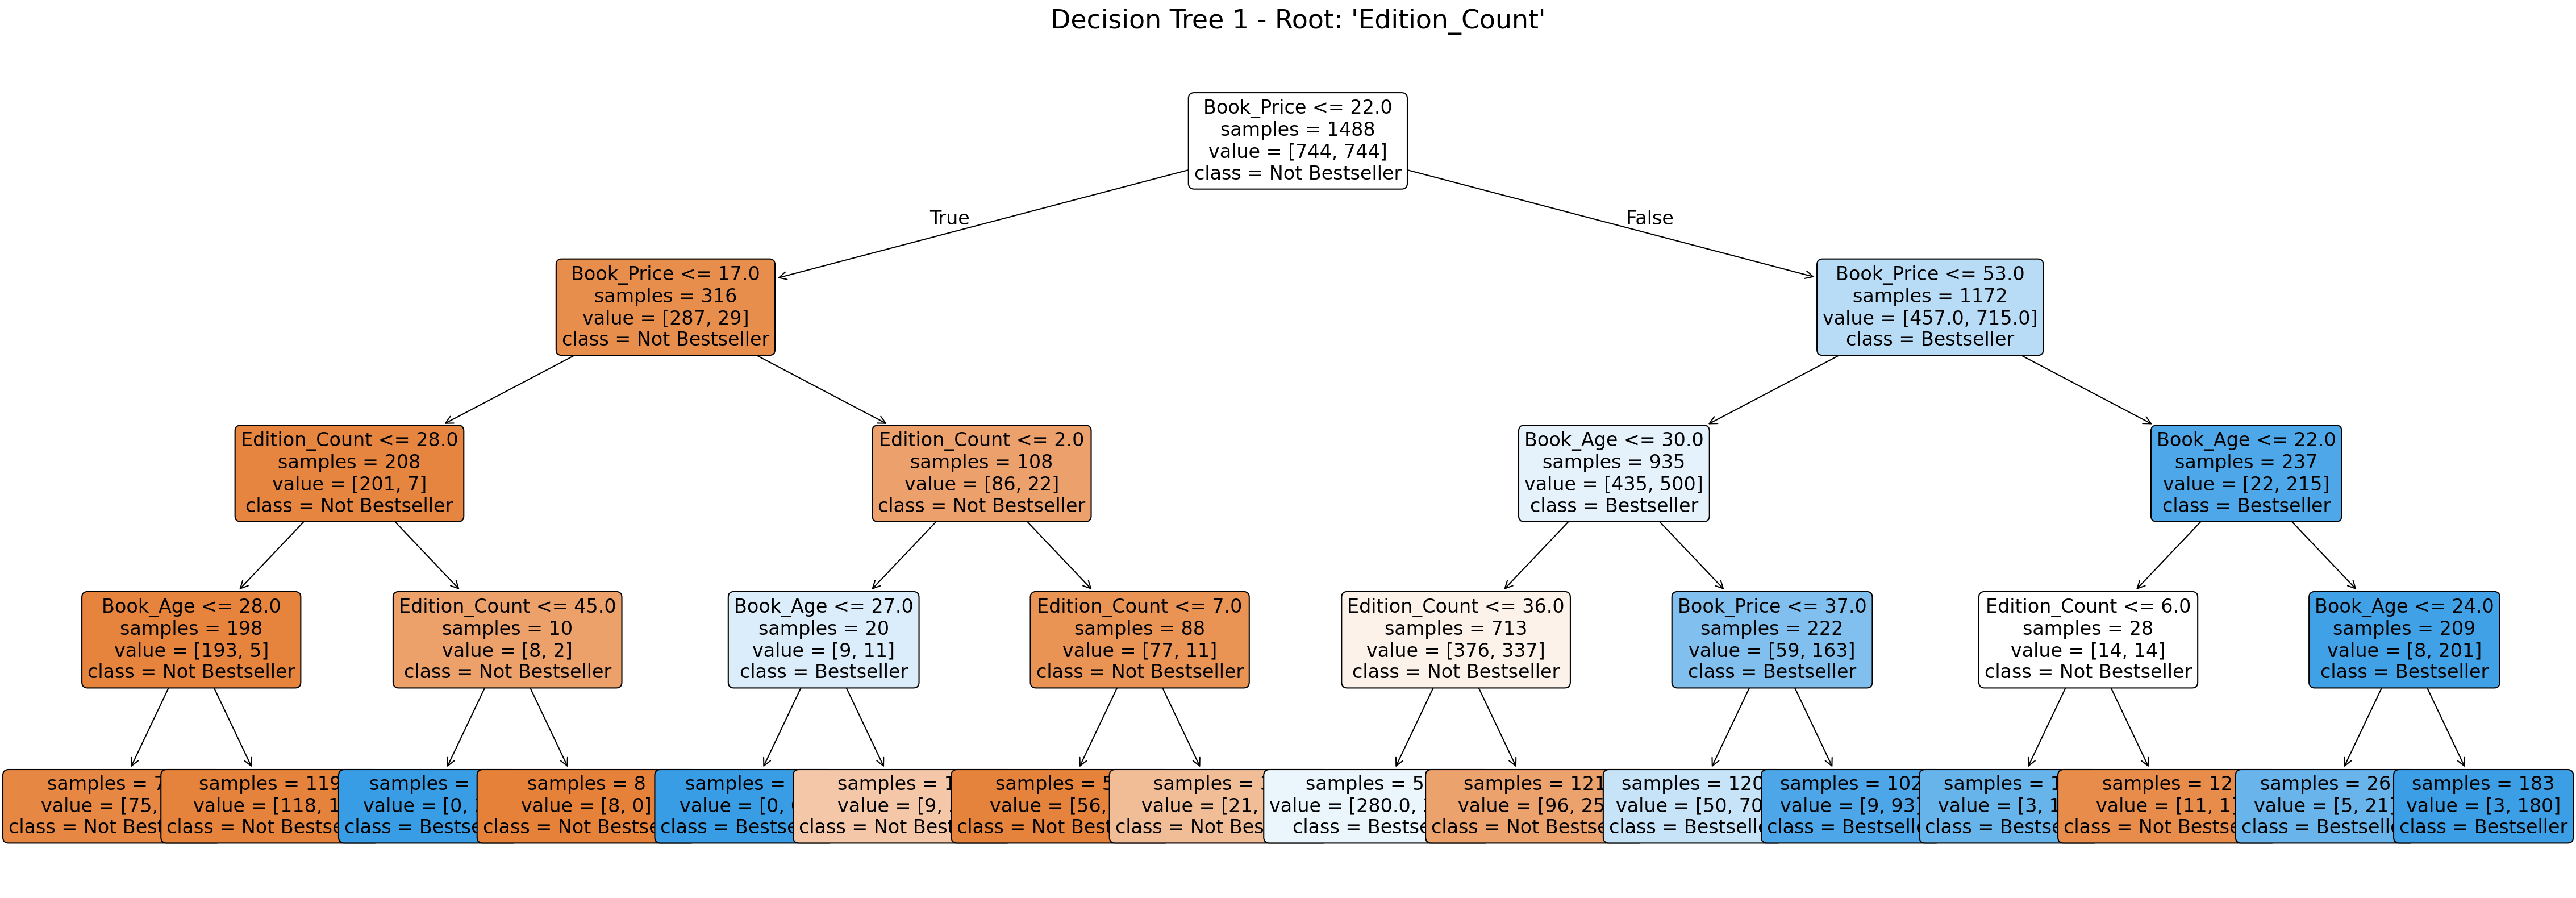

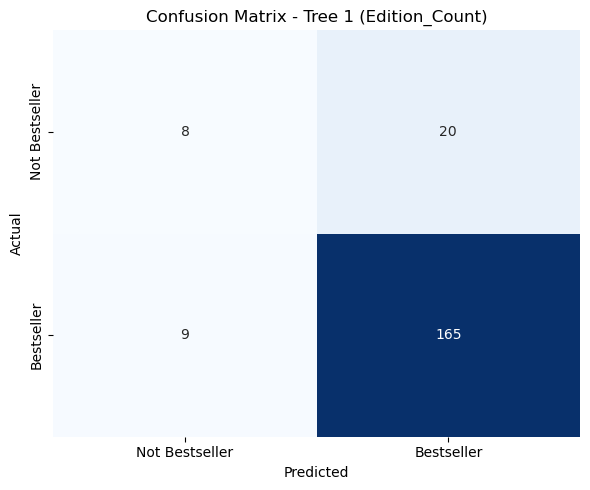

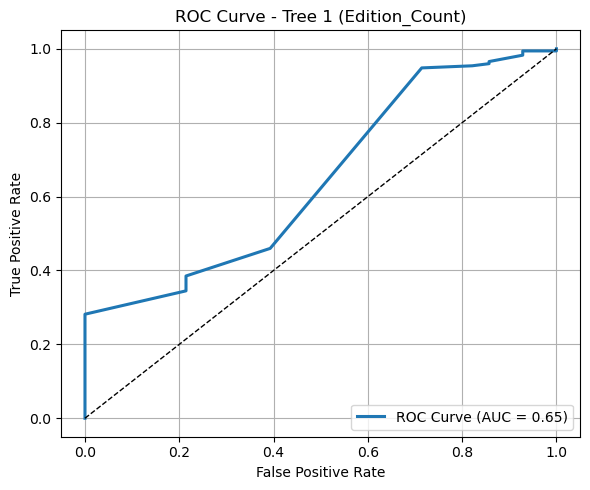


=== Decision Tree 2 - Root Influenced by 'Book_Price' ===
Confusion Matrix:
[[  8  20]
 [  9 165]]
Accuracy: 0.8564


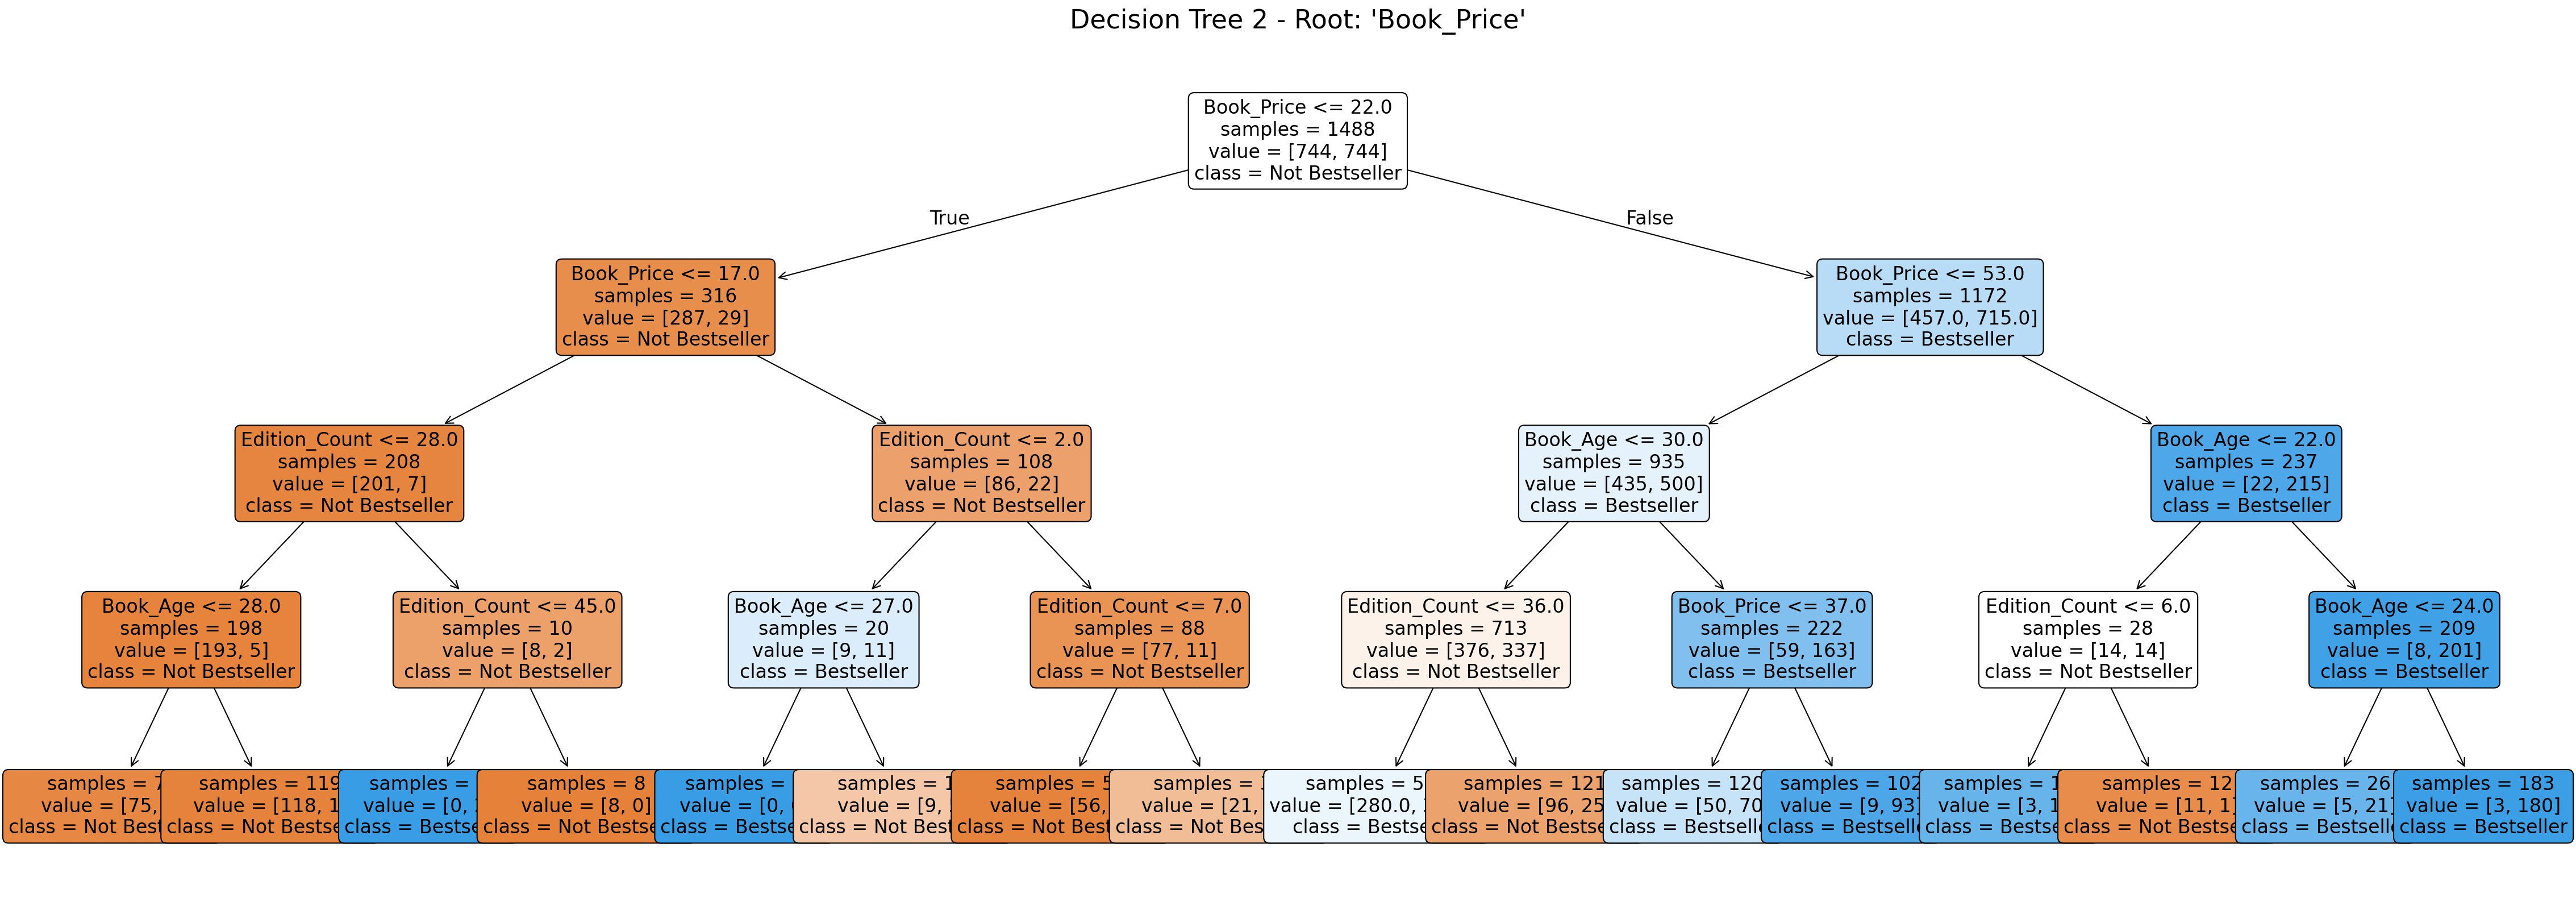

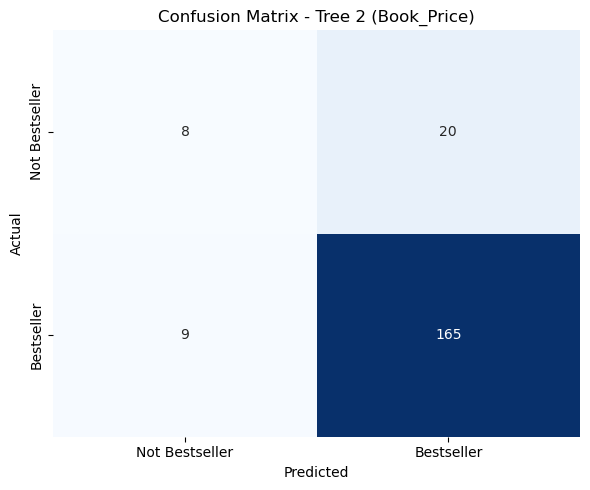

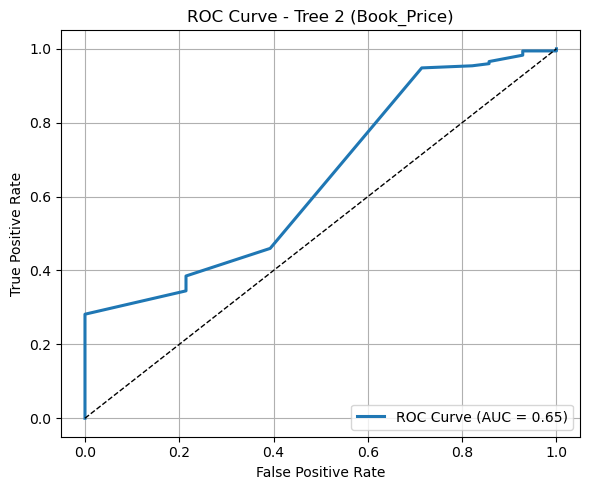


=== Decision Tree 3 - Root Influenced by 'Book_Age' ===
Confusion Matrix:
[[  8  20]
 [  9 165]]
Accuracy: 0.8564


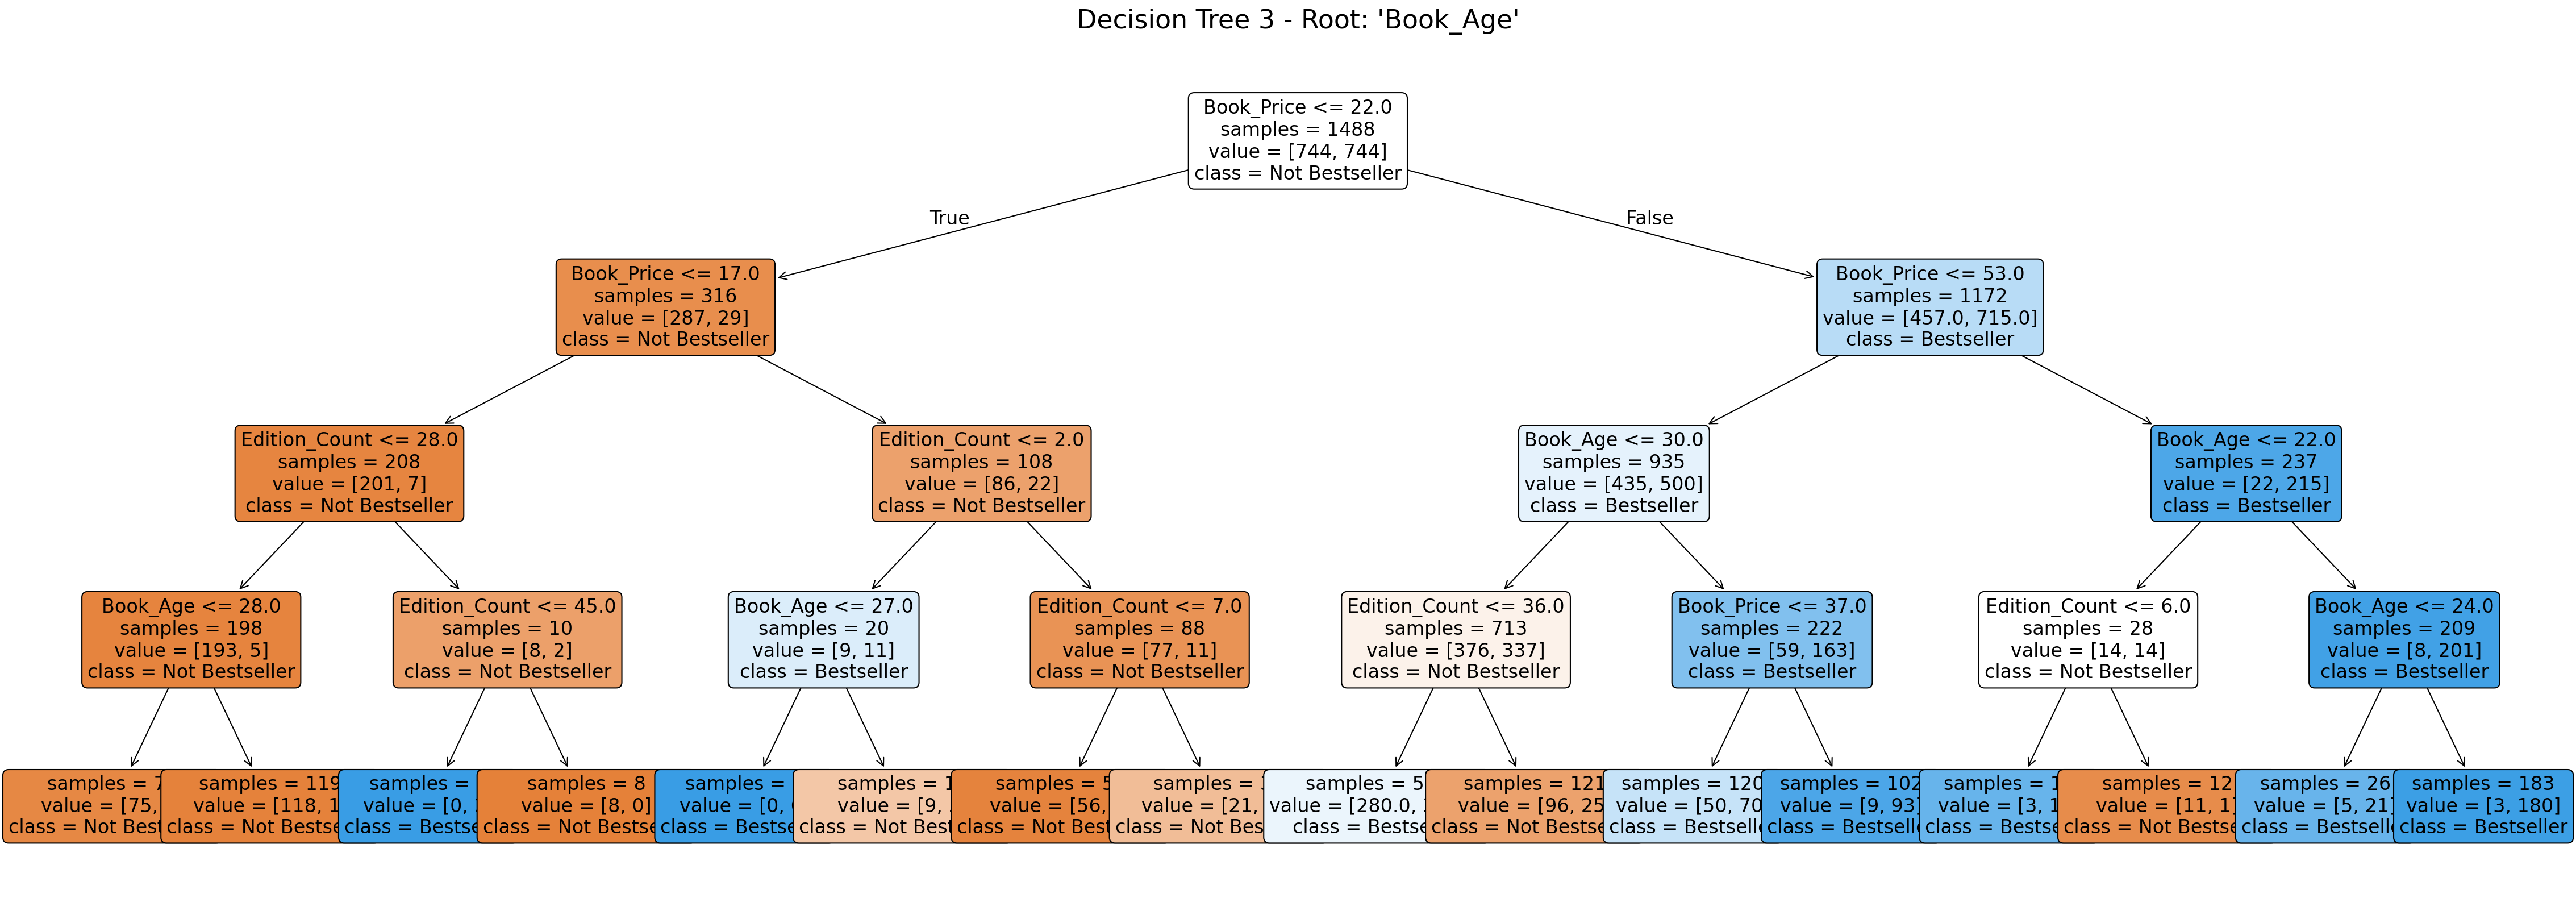

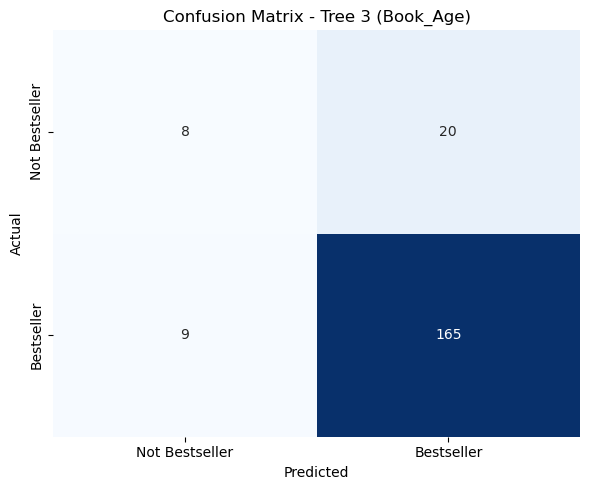

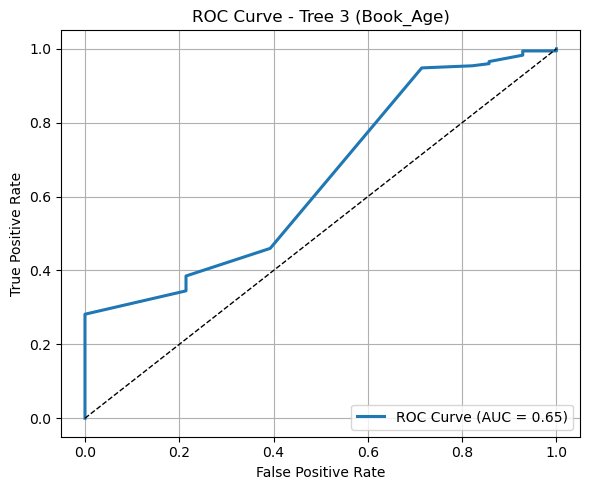

In [41]:
for i, (feature, model, cols, cm, acc, fpr, tpr, roc_auc) in enumerate(trees, 1):
    print(f"\n=== Decision Tree {i} - Root Influenced by '{feature}' ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {acc:.4f}")

    fig = plt.figure(figsize=(32, 12), dpi=150)  
    plot_tree(
        model,
        feature_names=cols,
        class_names=["Not Bestseller", "Bestseller"],
        filled=True,
        rounded=True,
        impurity=False,
        precision=0,
        fontsize=16
    )
    plt.title(f"Decision Tree {i} - Root: '{feature}'", fontsize=22, pad=25)
    plt.tight_layout(pad=6.0)
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Bestseller", "Bestseller"],
                yticklabels=["Not Bestseller", "Bestseller"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Tree {i} ({feature})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2.2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Tree {i} ({feature})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

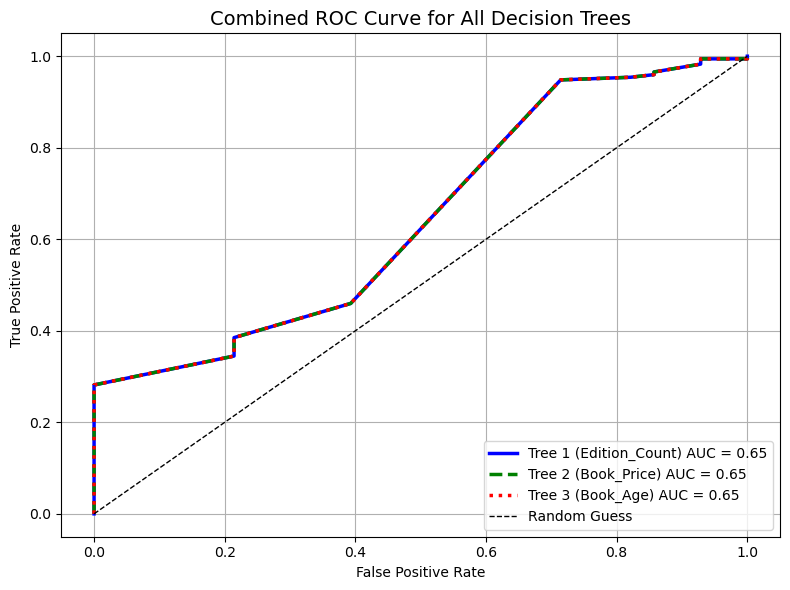

In [47]:
plt.figure(figsize=(8, 6))

styles = [
    {'color': 'blue', 'linestyle': '-', 'label': ''},
    {'color': 'green', 'linestyle': '--', 'label': ''},
    {'color': 'red', 'linestyle': ':', 'label': ''}
]
for i, (feature, _, _, _, _, fpr, tpr, roc_auc) in enumerate(trees):
    style = styles[i]
    label = f"Tree {i+1} ({feature}) AUC = {roc_auc:.2f}"
    plt.plot(fpr, tpr, color=style['color'], linestyle=style['linestyle'],
             linewidth=2.5, label=label)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')

plt.title("Combined ROC Curve for All Decision Trees", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()